In [2]:
%matplotlib inline

import ROOT
from ROOT import TCanvas, TH1F, TLegend
#from NNDefs import build_and_train_class_nn
from LayersDefs import get_signal_and_background_frames, calculate_derived_et_columns, \
    background_eff_at_target_signal_eff, manual_train_1d, \
    min_manual_eff_1d, manual_train_2d, min_manual_eff_2d
from sklearn.model_selection import train_test_split
import math
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook as tqdm

Welcome to JupyROOT 6.18/00


In [13]:
#random.seed(7)
#np.random.seed(7)

total_steps = 101

weight_steps = [0.1 * i for i in range(total_steps)]

ninety_percent_efficiencies = np.ones([total_steps])

#signal_frame, background_frame = get_signal_and_background_frames()
signal_frame, background_frame = get_signal_and_background_frames('/eos/user/n/nicholas/SWAN_projects/NewTauSamples/dataFiles/ztt_LayerEts.root', '/eos/user/n/nicholas/SWAN_projects/NewTauSamples/dataFiles/MB80_LayerEts.root')

calculate_derived_et_columns(signal_frame, background_frame)

signal_events = len(signal_frame)

# Find number of signal events that must be cut to fall below 90% efficiency
sig_events_to_cut = math.ceil(signal_events * 0.1)

calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1], column_names=['L0Et', 'L1Et'],
                                     output_column_name='L0+L1Et')
calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1], column_names=['L2Et', 'L3Et'],
                                     output_column_name='L2+L3Et')
calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1, 1], column_names=['L2Et', 'L3Et', 'HadEt'],
                                     output_column_name='L2+L3+HadEt')
calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1, 1, 1], column_names=['L0Et', 'L1Et', 'L2Et', 'L3Et'],
                                     output_column_name='EMEt')

In [6]:
efficiencies_1d = manual_train_1d(signal_frame, background_frame, ['EMEt', 'HadEt'], weight_steps)

In [7]:
min_eff_1d, min_weight_1d = min_manual_eff_1d(efficiencies_1d, weight_steps)

print(efficiencies_1d)
print(min_eff_1d)
print(min_weight_1d)

[0.62231169 0.48768266 0.39538589 0.32265493 0.27903373 0.25819346
 0.23072021 0.22261003 0.21299367 0.20501383 0.20137873 0.1965271
 0.19348579 0.18524526 0.182566   0.17716404 0.17867022 0.17561442
 0.17224    0.16864835 0.16557807 0.1664615  0.16305812 0.15956784
 0.16048024 0.16127677 0.16178366 0.15849614 0.1591044  0.15586033
 0.15629481 0.15438312 0.14916943 0.14947356 0.14773567 0.14637431
 0.14675086 0.14388333 0.14411505 0.14433229 0.14457849 0.14472331
 0.14479572 0.14191371 0.14191371 0.14197164 0.14205854 0.14211647
 0.14224681 0.14230474 0.14233371 0.1424206  0.14243508 0.14244956
 0.14247853 0.14253646 0.13930687 0.13643934 0.13404973 0.13351388
 0.13354285 0.13354285 0.13354285 0.13354285 0.13354285 0.13355733
 0.13355733 0.13355733 0.13355733 0.13355733 0.13355733 0.13355733
 0.13355733 0.13355733 0.13355733 0.13355733 0.13357181 0.13357181
 0.13357181 0.13358629 0.13358629 0.13358629 0.13358629 0.13358629
 0.13358629 0.13358629 0.13358629 0.13358629 0.13358629 0.13358

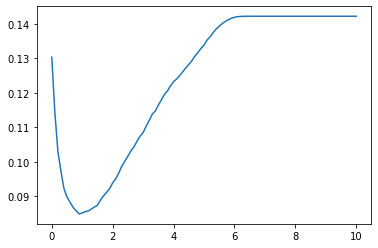

In [5]:
plt.plot(weight_steps, efficiencies_1d)
plt.show()

In [11]:
calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[1, 1, 1], column_names=['L0+L1Et', 'L2+L3Et', 'HadEt'], output_column_name='WeightedEt')
#print(signal_frame[['WeightedEt']][2470:2475])
#print(background_frame[['WeightedEt']][2470:2475])
print(background_eff_at_target_signal_eff(signal_frame, background_frame, 'WeightedEt', 0.9))

0.08521914780852191


In [14]:
ninety_percent_efficiencies_2d = manual_train_2d(signal_frame, background_frame, ['L0+L1Et', 'L2+L3Et', 'HadEt'], weight_steps)

In [16]:
x_steps, y_steps = np.meshgrid(weight_steps, weight_steps)

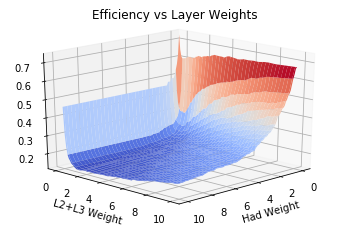

In [18]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x_steps, y_steps, ninety_percent_efficiencies_2d, cmap=cm.coolwarm)
ax.set_title('Efficiency vs Layer Weights')
ax.set_xlabel('Had Weight')
ax.set_ylabel('L2+L3 Weight')
#ax.set_zlabel('Efficiency')
# ax.set_zlabel('Background Efficiency')
ax.view_init(elev=20, azim=45)

In [8]:
min_eff, min_l2l3, min_had = min_manual_eff_2d(ninety_percent_efficiencies_2d, weight_steps)
print(min_eff)
print(min_l2l3)
print(min_had)

0.08129918700812992
1.6
1.4000000000000001


In [7]:
total_steps = 21

weight_steps = [0.2 * i for i in range(total_steps)]

min_eff = float('inf')
min_l0_weight = 0
min_l2_weight = 0
min_l3_weight = 0
min_had_weight = 0

for l0_weight in tqdm(weight_steps):
    for l2_weight in weight_steps:
        for l3_weight in weight_steps:
            for had_weight in weight_steps:
                calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[l0_weight, 1, l2_weight, l3_weight, had_weight], 
                                     column_names=['L0Et', 'L1Et', 'L2Et', 'L3Et', 'HadEt'], output_column_name='WeightedEt')

                end_background_efficiency = background_eff_at_target_signal_eff(signal_frame, background_frame, 'WeightedEt', 0.9)

                if end_background_efficiency == 0:
                    continue
                if end_background_efficiency < min_eff:
                    min_eff = end_background_efficiency
                    min_l0_weight = l0_weight
                    min_l2_weight = l2_weight
                    min_l3_weight = l3_weight
                    min_had_weight = had_weight
                    
print(min_eff)
print(min_l0_weight)
print(min_l2_weight)
print(min_l3_weight)
print(min_had_weight)

KeyboardInterrupt: 

In [ ]:
Min efficiency and weights for all five layers from 0 to 2 in steps of 0.1:
0.07967920320796792
0.6000000000000001
1.2000000000000002
2.0
1.1



In [16]:
calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[0.6, 1, 1.2, 2, 1.1], column_names=['L0Et', 'L1Et', 'L2Et', 'L3Et', 'HadEt'], output_column_name='WeightedEt')
#print(signal_frame[['WeightedEt']][2470:2475])
#print(background_frame[['WeightedEt']][2470:2475])
print(background_eff_at_target_signal_eff(signal_frame, background_frame, 'WeightedEt', 0.9))

0.07967920320796792


In [10]:
print(weight_steps)

[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2000000000000002, 1.4000000000000001, 1.6, 1.8, 2.0, 2.2, 2.4000000000000004, 2.6, 2.8000000000000003, 3.0, 3.2, 3.4000000000000004, 3.6, 3.8000000000000003, 4.0, 4.2, 4.4, 4.6000000000000005, 4.800000000000001, 5.0, 5.2, 5.4, 5.6000000000000005, 5.800000000000001, 6.0, 6.2, 6.4, 6.6000000000000005, 6.800000000000001, 7.0, 7.2, 7.4, 7.6000000000000005, 7.800000000000001, 8.0]


In [4]:
total_steps = 21

weight_steps = [0.1 * i for i in range(total_steps)]

min_eff = float('inf')
min_l0_weight = 0
min_l3_weight = 0
min_had_weight = 0

for l0_weight in tqdm(weight_steps):
    for l3_weight in weight_steps:
        for had_weight in weight_steps:
            calculate_derived_et_columns(signal_frame, background_frame, layer_weights=[l0_weight, 1, 1, l3_weight, had_weight], 
                                     column_names=['L0Et', 'L1Et', 'L2Et', 'L3Et', 'HadEt'], output_column_name='WeightedEt')

            end_background_efficiency = background_eff_at_target_signal_eff(signal_frame, background_frame, 'WeightedEt', 0.9)

            if end_background_efficiency == 0:
                continue
            if end_background_efficiency < min_eff:
                min_eff = end_background_efficiency
                min_l0_weight = l0_weight
                min_l3_weight = l3_weight
                min_had_weight = had_weight
                    
print(min_eff)
print(min_l0_weight)
print(min_l3_weight)
print(min_had_weight)


0.08062919370806292
0.5
1.9000000000000001
1.0


In [ ]:
min_eff = float('inf')
min_i = 0
min_j = 0
min_k = 0
min_l = 0
for i in range(total_steps):
    file_name = f'4DManualWeights/L1Weight{i}.txt'
    
    with open(file_name, 'r') as f:
        for line in f.readlines():
            split_line = line.split('=')
            efficiency = float(split_line[0][:-3])
            j = int(split_line[2][:-2])
            k = int(split_line[3][:-2])
            l = int(split_line[4])    
        
            if efficiency == 0:
                continue
            if efficiency < min_eff:
                min_eff = efficiency
                min_i = i
                min_j = j
                min_k = k
                min_l = l

print(min_eff)
print(min_i)
print(min_j)
print(min_k)
print(min_l)

In [40]:
l0l1_weight = 1
l2l3_weight = 4
had_weight = 5

j = l2l3_weight * 10
k = had_weight * 10

#print(weight_steps[20])
print(ninety_percent_efficiencies[j])
print(ninety_percent_efficiencies_2d[j][k])

total_steps_4d = 41
weight_steps_4d = [0.2 * i for i in range(total_steps)]

l = l2l3_weight * 5
m = had_weight * 5

#print(weight_steps_4d[10])

file_name = f'4DManualWeights/L1Weight5.txt'
with open(file_name, 'r') as f:
    lines = f.readlines()
line_num = l * 41 * 41 + l * 41 + m
print(lines[line_num].split('-')[0])

0.1818998102796565
0.16899593042621905
0.16899593042621905 
